In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-prediction/master_dataset.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("/kaggle/input/covid-19-prediction/master_dataset.csv",low_memory=False)

In [4]:
current_columns = df.columns.tolist()
new_columns = current_columns[1:] + ['empty_column']
df_fixed = df.copy()
df_fixed.columns = new_columns
df = df_fixed.drop('empty_column', axis=1)

In [5]:
df = df[['sex', 'age', 'bmi','smoking','alcohol','cannabis','amphetamines','cocaine','contacts_count','working','rate_reducing_risk_single','rate_reducing_mask','covid19_symptoms','covid19_contact','asthma','kidney_disease','liver_disease','compromised_immune','heart_disease','lung_disease','diabetes','hiv_positive','hypertension','other_chronic','nursing_home','health_worker','covid19_positive']]

In [6]:
def process_age_column(df, age_column='age'):
    """
    Process age column containing string ranges like '20_30' to their average values
    and handle null values by replacing them with mean.
    
    Parameters:
    df: pandas DataFrame
    age_column: str, name of the age column (default='age')
    
    Returns:
    pandas Series with processed age values
    """
    def extract_average(age_str):
        if pd.isna(age_str):
            return np.nan
        try:
            # Split the string on '_' and convert to integers
            start, end = map(int, str(age_str).split('_'))
            return (start + end) / 2
        except:
            return np.nan
    
    # Convert string ranges to averages
    processed_ages = df[age_column].apply(extract_average)
    
    # Replace null values with mean
    mean_age = processed_ages.mean()
    processed_ages = processed_ages.fillna(mean_age)
    
    return processed_ages

df['age'] = process_age_column(df, age_column='age')

In [7]:
categorical_cols = ['sex', 'age', 'smoking', 'alcohol', 'working', 'cannabis', 
                       'amphetamines', 'cocaine']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

In [8]:
numerical_cols = ['bmi', 'contacts_count', 'rate_reducing_mask']
for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mean())

In [9]:
nominal_cols = ['sex', 'smoking', 'working']
df_encoded = pd.get_dummies(df, columns=nominal_cols)
drug_cols = ['cannabis', 'amphetamines', 'cocaine']
for col in drug_cols:
    if col in df_encoded.columns:
        df_encoded[col] = pd.to_numeric(df_encoded[col], errors='coerce')
df=df_encoded

In [10]:
# Convert boolean columns to int (True becomes 1, False becomes 0)
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

def remove_outliers(df, features):
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Exclude target column from features list
cols_to_check = [col for col in df.columns if col != 'covid19_positive']
df = remove_outliers(df, cols_to_check)


In [11]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN

# Normalize features
scaler = MinMaxScaler()
cols_to_normalize = [col for col in df.columns if col != 'covid19_positive']
df_normalized = df.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Apply SMOTEENN
X = df_normalized[cols_to_normalize]  # Features
y = df_normalized['covid19_positive']  # Target variable

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Convert back to DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=cols_to_normalize)
df_resampled['covid19_positive'] = y_resampled

# Final dataset
df = df_resampled

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training deeper autoencoder...
Epoch 1/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.0149 - val_loss: 3.3977e-04 - learning_rate: 0.0010
Epoch 2/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 8.7613e-04 - val_loss: 1.9251e-04 - learning_rate: 0.0010
Epoch 3/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 6.6811e-04 - val_loss: 2.2457e-04 - learning_rate: 0.0010
Epoch 4/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 5.7409e-04 - val_loss: 1.6928e-04 - learning_rate: 0.0010
Epoch 5/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 5.0109e-04 - val_loss: 1.7176e-04 - learning_rate: 0.0010
Epoch 6/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 4.5509e-04 - val_loss: 1.7541e-04 - learning_rate: 0.0010
Epoch 7/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 4.2121e-04 - val_loss: 1.5373e-04 - learning_rate: 0.0010
Epoch 8/1000
8329/8329 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 3.9755e-04 - val_loss: 1.6167e-04 - learning_ra

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training ANN on encoded features with optimized architecture...
Epoch 1/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7593 - loss: 0.5203 - val_accuracy: 0.8433 - val_loss: 0.3654 - learning_rate: 5.0000e-04
Epoch 2/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8204 - loss: 0.4081 - val_accuracy: 0.8781 - val_loss: 0.3058 - learning_rate: 5.0000e-04
Epoch 3/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8422 - loss: 0.3684 - val_accuracy: 0.8910 - val_loss: 0.2790 - learning_rate: 5.0000e-04
Epoch 4/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8543 - loss: 0.3446 - val_accuracy: 0.9035 - val_loss: 0.2510 - learning_rate: 5.0000e-04
Epoch 5/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8616 - loss: 0.3299 - val_accuracy: 0.9138 - val_loss: 0.2273 - learning_rate: 5.0000e-04
Epoch 6/1000
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8689 - loss: 0.3149 - val_accuracy: 0.9150 - val_loss: 0.2218 - 

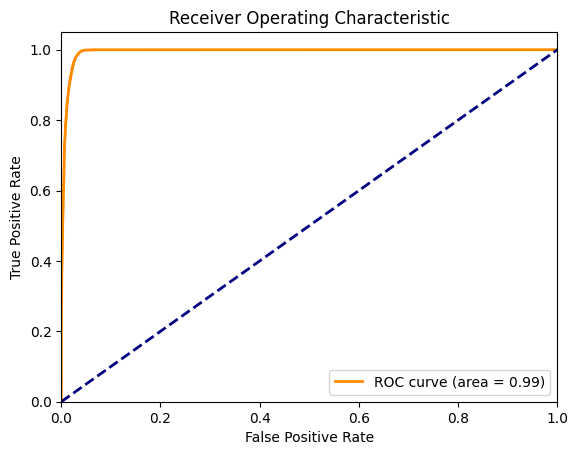

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

X = df.drop('covid19_positive', axis=1).values
y = df['covid19_positive'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
encoding_dim = 15
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(128)(input_layer)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(64)(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(encoding_dim)(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)
decoded = Dense(64)(encoded)
decoded = LeakyReLU(alpha=0.01)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(128)(decoded)
decoded = LeakyReLU(alpha=0.01)(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
early_stop_ae = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr_ae = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6)
print("Training deeper autoencoder...")
autoencoder.fit(X_train, X_train, validation_split=0.2, epochs=1000, batch_size=16, callbacks=[early_stop_ae, reduce_lr_ae], verbose=1)
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
def create_optimized_ann(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
ann_model = create_optimized_ann(input_dim=encoding_dim)
early_stop_ann = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr_ann = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6)
print("\nTraining ANN on encoded features with optimized architecture...")
ann_model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=1000, batch_size=64, callbacks=[early_stop_ann, reduce_lr_ann], verbose=1)
y_pred_encoded = (ann_model.predict(X_test_encoded) > 0.5).astype(int)
print("\nOptimized ANN on Encoded Features Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_encoded))
print("Precision:", precision_score(y_test, y_pred_encoded, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_encoded, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_encoded, zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_encoded, zero_division=0))
cm = confusion_matrix(y_test, y_pred_encoded)
print("\nConfusion Matrix:\n", cm)
y_pred_prob = ann_model.predict(X_test_encoded)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
